# Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts Using Java.*



# Setup

First, let's make sure this notebook works well in :

In [90]:
%maven commons-io:commons-io:jar:2.6
%maven io.vavr:vavr:jar:0.10.0
%maven org.apache.commons:commons-compress:1.18
    
    
import org.apache.commons.io.*;
import java.io.*;
import io.vavr.control.*;
import org.apache.commons.compress.archivers.tar.*;
import org.apache.commons.compress.compressors.gzip.*;

var DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/";
var HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz";
var PROJECT_ROOT_DIR = ".";
var CHAPTER_ID = "end_to_end_project";
var HOUSING_PATH = FilenameUtils.concat("datasets", "housing");
var BUFFER_SIZE = 1024;
void fetch_housing_data(String housingUrl, File housingPath){
   housingUrl = Objects.toString(housingUrl,HOUSING_URL);
   Objects.requireNonNull(housingPath);
   if(!housingPath.exists()){
       Try.run(() -> FileUtils.forceMkdir(housingPath));
   }
   var tgzPath = new File(FilenameUtils.concat(housingPath.getPath(), "housing.tgz"));
   var urlTemp = housingUrl;
   Try.run(() -> FileUtils.copyURLToFile(new URL(urlTemp), tgzPath )); 
   Try.run(() -> extractTarGZ(tgzPath, housingPath) );
}

void extractTarGZ(File in, File destDir) throws Exception {
    GzipCompressorInputStream gzipIn = new GzipCompressorInputStream(new FileInputStream(in));
    try (TarArchiveInputStream tarIn = new TarArchiveInputStream(gzipIn)) {
        TarArchiveEntry entry;

        while ((entry = (TarArchiveEntry) tarIn.getNextEntry()) != null) {
            /** If the entry is a directory, create the directory. **/
            if (entry.isDirectory()) {
                File f = new File(FilenameUtils.concat(destDir.getPath(),entry.getName()));
                boolean created = f.mkdir();
                if (!created) {
                    System.out.printf("Unable to create directory '%s', during extraction of archive contents.\n",
                            f.getAbsolutePath());
                }
            } else {
                int count;
                byte data[] = new byte[BUFFER_SIZE];
                FileOutputStream fos = new FileOutputStream(FilenameUtils.concat(destDir.getPath(),entry.getName()), false);
                try (BufferedOutputStream dest = new BufferedOutputStream(fos, BUFFER_SIZE)) {
                    while ((count = tarIn.read(data, 0, BUFFER_SIZE)) != -1) {
                        dest.write(data, 0, count);
                    }
                }
            }
        }

    }
}


In [91]:
fetch_housing_data(HOUSING_URL, new File(HOUSING_PATH));

In [92]:
%maven com.d3xsystems:morpheus-core:jar:1.0.3
%maven com.zavtech:morpheus-viz:jar:0.9.21
//https://github.com/zavtech/morpheus-core/blob/master/README.md

import com.zavtech.morpheus.frame.*;

DataFrame<String,String> load_housing_data(File housingPathCsv){
 return DataFrame.read().csv(housingPathCsv);
}


In [93]:

var housing = load_housing_data(new File(FilenameUtils.concat(HOUSING_PATH,"housing.csv")));
housing.out().print(4);


 Index  |  longitude  |  latitude  |  housing_median_age  |  total_rooms  |  total_bedrooms  |  population  |  households  |  median_income  |  median_house_value  |  ocean_proximity  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
     0  |  -122.2300  |   37.8800  |             41.0000  |     880.0000  |        129.0000  |    322.0000  |    126.0000  |         8.3252  |         452600.0000  |         NEAR BAY  |
     1  |  -122.2200  |   37.8600  |             21.0000  |    7099.0000  |       1106.0000  |   2401.0000  |   1138.0000  |         8.3014  |         358500.0000  |         NEAR BAY  |
     2  |  -122.2400  |   37.8500  |             52.0000  |    1467.0000  |        190.0000  |    496.0000  |    177.0000  |         7.2574  |         352100.0000  |         NEAR BAY  |
     3  |  -122.2500  |   37.8500  |             52.0000  |    1274.0

In [94]:
//planning to replicate housing.info()
display(housing);
System.out.println(housing.cols().types());

DataFrame[20640x10] rows=[0...20639], columns=[longitude...ocean_proximity]

java.util.stream.ReferencePipeline$3@43c0de41


In [95]:
import java.util.stream.Collectors;


display(housing.cols().select("ocean_proximity").colAt(0).toValueStream().collect(Collectors.groupingBy(string -> string, Collectors.counting())));
housing.rows().groupBy("ocean_proximity").forEach(0, (groupKey, group) -> {
    System.out.printf("There are %s rows for group %s\n", group.rowCount(), groupKey);
});
housing.rows().groupBy("ocean_proximity").stats(0).count().rows().sort(true).out().print(formats -> {
    formats.setDecimalFormat("0;-0", 1);
});

{INLAND=6551, ISLAND=5, NEAR BAY=2290, NEAR OCEAN=2658, <1H OCEAN=9136}

There are 6551 rows for group (INLAND)
There are 9136 rows for group (<1H OCEAN)
There are 5 rows for group (ISLAND)
There are 2290 rows for group (NEAR BAY)
There are 2658 rows for group (NEAR OCEAN)

    Index      |  longitude  |  latitude  |  housing_median_age  |  total_rooms  |  total_bedrooms  |  population  |  households  |  median_income  |  median_house_value  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  (<1H OCEAN)  |       9136  |      9136  |                9136  |         9136  |            9034  |        9136  |        9136  |           9136  |                9136  |
     (INLAND)  |       6551  |      6551  |                6551  |         6551  |            6496  |        6551  |        6551  |           6551  |                6551  |
     (ISLAND)  |          5  |         5  |                   5  |            5  |               5  |     

In [96]:
import com.zavtech.morpheus.stats.StatType;
housing.cols().describe(StatType.COUNT ,StatType.MAX ,StatType.MEAN ,StatType.MIN, StatType.STD_DEV, StatType.PERCENTILE  ).out().print();



       Index         |    COUNT     |      MAX      |       MEAN        |     MIN      |      STD_DEV      |  PERCENTILE   |
----------------------------------------------------------------------------------------------------------------------------
          longitude  |  20640.0000  |       0.0000  |    -119.56970446  |   -124.3500  |       2.00353172  |    -118.4900  |
           latitude  |  20640.0000  |      41.9500  |      35.63186143  |     32.5400  |        2.1359524  |      34.2600  |
 housing_median_age  |  20640.0000  |      52.0000  |      28.63948643  |      1.0000  |      12.58555761  |      29.0000  |
        total_rooms  |  20640.0000  |   39320.0000  |     2635.7630814  |      2.0000  |    2181.61525158  |    2127.0000  |
     total_bedrooms  |  20433.0000  |    6445.0000  |     537.87055254  |      1.0000  |     421.38507007  |     435.0000  |
         population  |  20640.0000  |   35682.0000  |    1425.47674419  |      3.0000  |    1132.46212177  |    1166.0000  |

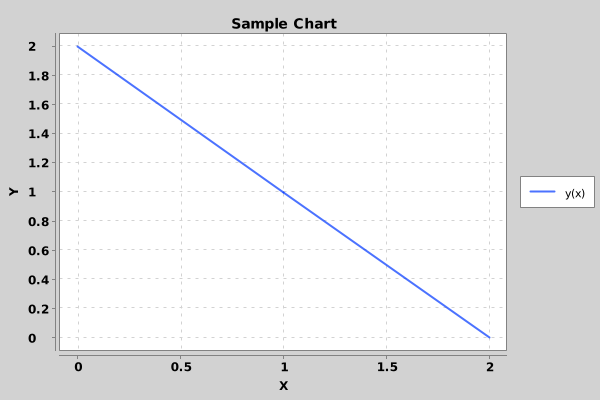

In [99]:
%maven org.knowm.xchart:xchart:3.5.2
import org.knowm.xchart.*;
double[] xData = new double[] { 0.0, 1.0, 2.0 };
double[] yData = new double[] { 2.0, 1.0, 0.0 };

XYChart chart = QuickChart.getChart("Sample Chart", "X", "Y", "y(x)", xData, yData);
BitmapEncoder.getBufferedImage(chart);

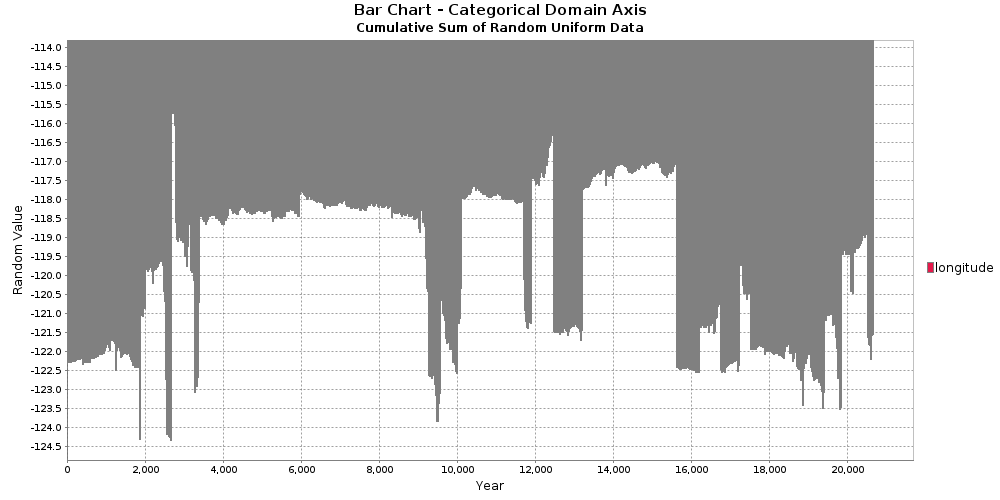

com.zavtech.morpheus.viz.jfree.JFXyChart@717ee8d5

In [119]:
import com.zavtech.morpheus.viz.chart.*;
import javax.imageio.ImageIO;
Chart.create().withBarPlot(housing.cols().select("longitude"), false, chart -> {
    chart.plot().axes().domain().label().withText("Year");
    chart.plot().axes().range(0).label().withText("Random Value");
    chart.title().withText("Bar Chart - Categorical Domain Axis");
    chart.subtitle().withText("Cumulative Sum of Random Uniform Data");
    chart.legend().on();
    ByteArrayOutputStream output = new ByteArrayOutputStream();
    
    chart.writerPng(output, 1000,500, false);
    display(Try.of(()-> ImageIO.read(new ByteArrayInputStream(output.toByteArray()))).get());
});
